In [2]:
import jax 
import jax.numpy as jnp
from jax import jacfwd, jacrev
import jax.scipy as jsp
from jax import grad, value_and_grad
from jax import vmap
from jax import random
from jax import lax
from jax.experimental import optimizers

import numpy as np
from tqdm.notebook import tqdm
from functools import partial
import pickle
import matplotlib.pyplot as plt
import nibabel as nib
from skimage.transform import resize
import scipy
from scipy.ndimage import gaussian_filter, zoom
import copy
import math
import time

%matplotlib inline

from plotting import *
from epdiff import *
from grid_utils import *
from integrators import *
from regularization import *
from similarity import *

# First line of business is ----

1. Set it up so that it works in the 0-1 range 
2. Set it up so that it works with loss functions other than msq
3. Then add the spatially varying regularization 
4. Then add the mk-LNCC loss function 

## The equation to be solved is this ----

$argmin_{m_{0}}   E(m, \phi, v)$    

$ s.t. \partial_{t} \phi + J_{\phi}v = 0,     \phi_{0} = Id$  

$\partial_{t}m + J_{m}v  + mdiv(v) + J_{v}^{T}m = 0$  

$v = Km$  

where $E = 0.5*\int_{0}^{1} <m_t, Km_t>dt + Sim(I^0 \circ\phi_1, I^1) = 0.5*\int_{0}^{1} <m_0, Km_0>dt + Sim(I^0 \circ\phi_1, I^1)$

### need more metrics 
### need a test dataset 
### need a deep learning network
### need adaptive smoothing 

### a note on using jnp.gradient for spatial derivatives

spatial derivatives are computed using central differencing schemes with linear interpolation at the boundaries 

# more features 

1. ## custom derivative rules for advecting the equations ---- can be used to optimize the args better 
2. ## better finite differencing schemes in time and space ----- can be looked at 
3. ## cfl conditions etc for stability of the numerical schemes for integration etc ---- can be used to set the number of time steps
4. ## multiscale approach for registration ----- do this now , done boundary conditions can be looked into a bit more 
5. ## better formulation of the equation being used 
6. ## using better optimization algorithms for the actual optimization itself like momentum etc for the flow based thingy 
7. ## deep learning for predicting momentum
8. ## adaptive smoothing like rdmm

### more urgent

--- a multiscale approach to registration
--- more loss functions especially ants loss functions

In [4]:
def load_data(resize_im = False):

    fix = jnp.asarray(nib.load("circle.nii").dataobj)
    mov = jnp.asarray(nib.load("square.nii").dataobj)
    if resize_im:
        fix = resize(fix, (60, 60), anti_aliasing=True, preserve_range=True)
        mov = resize(mov, (60, 60), anti_aliasing=True, preserve_range=True)
    return fix, mov

In [5]:
fix, mov = load_data()

In [6]:
jax.config.update('jax_enable_x64', True)


In [7]:



def optimize(func, args, step_size, num_epochs):

    m0, fix, mov, t, sigma, K, odeint_rk4, smooth_across_components, smooth_across_time_and_components, advect_map_forward, data_matching, regularization = args
    opt_init, opt_update, get_params = optimizers.adam(step_size)
    opt_state = opt_init(m0)

    for epoch in tqdm(range(num_epochs)):
        
        loss, grads = func(get_params(opt_state), K, fix, mov, t, 
                           sigma,  odeint_rk4, smooth_across_components, smooth_across_time_and_components, 
                           advect_map_forward, data_matching, regularization)
        
        opt_state = opt_update(epoch, grads, opt_state)
        params = get_params(opt_state)
        
    return opt_state, loss, get_params


def data_matching(I, J, sim_measure):
    """
    data matching term 
    """
    return sim_measure(I, J)



def regularization(m0, K, smooth_across_components):
    
    v0 = smooth_across_components(m0, K)
    v_total  = jnp.sum(v0.flatten()*v0.flatten())
    return v_total



def cost_functional(m0, K, fix, mov, t, sigma, odeint_rk4,smooth_across_components,smooth_across_time_and_components, advect_map_forward, data_matching_measure, 
                   regularization):
    """
    the error term which is data matching + regularization 
    """
    
    def shoot(m0, t, K, odeint_rk4, smooth_across_time_and_components, advect_map_forward):
    
        m_int = odeint_rk4(get_dm_dt, m0, t, K, smooth_across_components)
        v_int = smooth_across_time_and_components(m_int, K)
        phi_id = identity_mapping(fix.shape)
        phi_ad_x, phi_ad_y = advect_map_forward(get_dphi_dt, phi_id, t, v_int)
        coords = jnp.asarray([phi_ad_y, phi_ad_x])
        warped = jax.scipy.ndimage.map_coordinates(mov, coords, order= 1)
        return warped
    
    warped = shoot(m0, t, K,  odeint_rk4, smooth_across_time_and_components, advect_map_forward)
    
    dm = (1/sigma)**2 * data_matching(fix, warped, data_matching_measure)
    
    reg = 0.5 * regularization(m0, K, smooth_across_components)
    
    
    return  dm + reg


In [8]:
### adaptive smoothing 

In [9]:

jit_grad_func = jax.jit(value_and_grad(cost_functional, argnums = 0), static_argnums=(6, 7, 8, 9, 10,11, ))
grad_func = value_and_grad(cost_functional, argnums = 0)
lncc = partial(compute_lncc, window = 5)

In [11]:
n_sigmas = 5

id_map = identity_mapping(fix.shape)
w, h = fix.shape

In [12]:

sigma_array = jnp.asarray([(5, 5), (10, 10), (15, 15), (20, 20), (25, 25)])
sigmas = (5, 10, 15, 20, 25)
K = vmap(get_normalized_gaussian_kernel, (None, None, 0))(id_map, (w//2, h//2), sigma_array)
raw_weights = jnp.ones(( n_sigmas, *fix.shape))
weights = vmap(vmap(jax.nn.softmax, 1), 2)(raw_weights)
weights.shape, K.shape

((120, 120, 5), (5, 120, 120))

In [22]:
fix, mov = load_data(resize_im = True)

In [23]:
from jax.config import config 
config.update("jax_debug_nans", True)

### actual optimization 

24.236804335974163


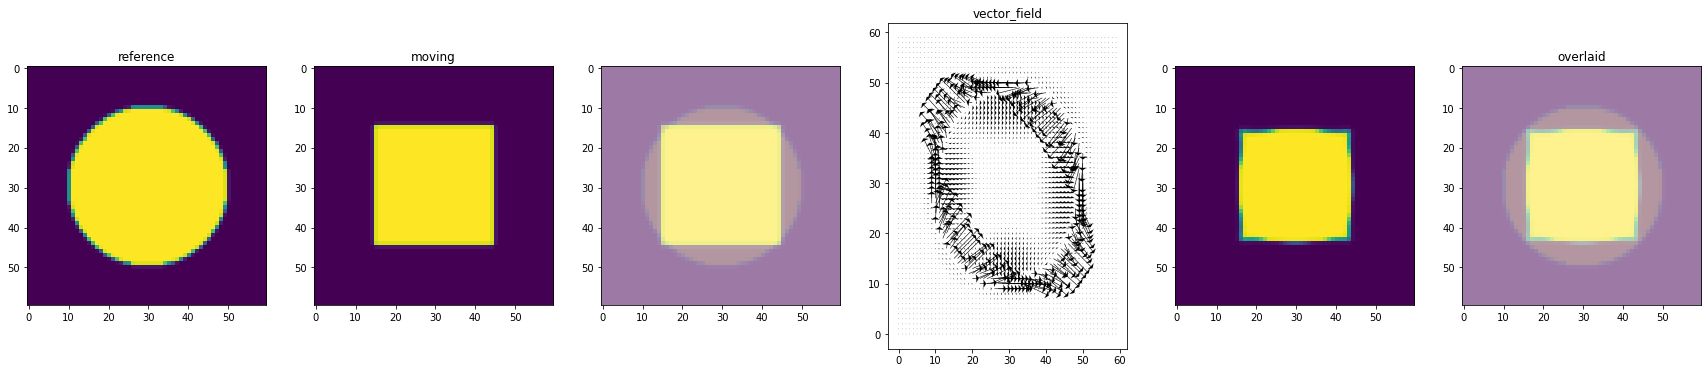

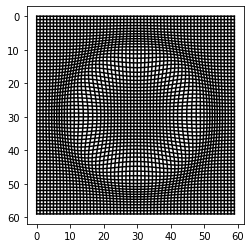

-16.747575193333933 2772.394017388465 0.01680216473774984
17.131822594044372


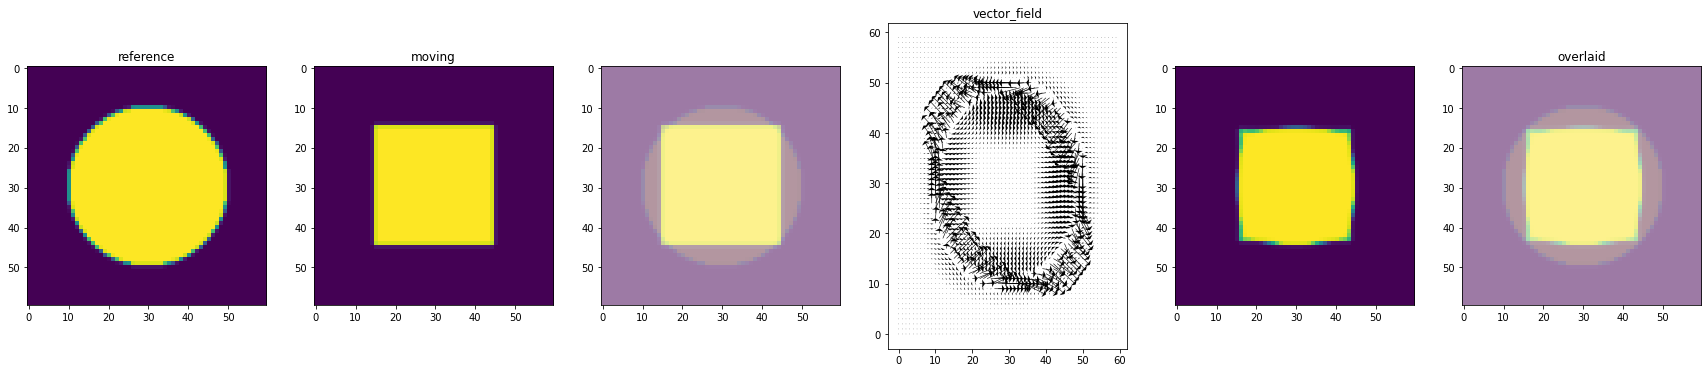

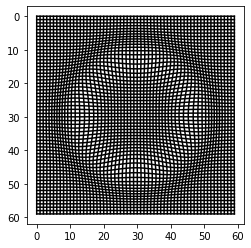

-19.874611813089054 1674.5692642235779 0.03659880035618591
16.60430663560248


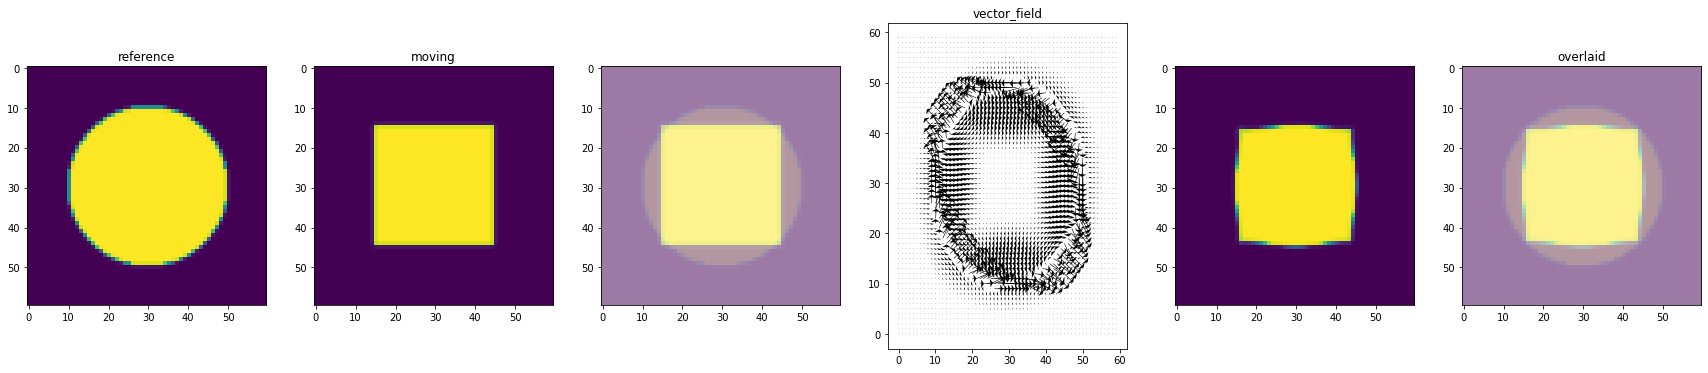

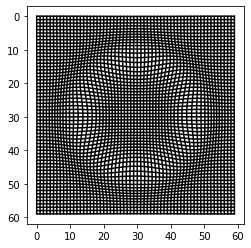

13.94209611450389 1160.6877441440513 0.02272647248567542
19.892814405876326


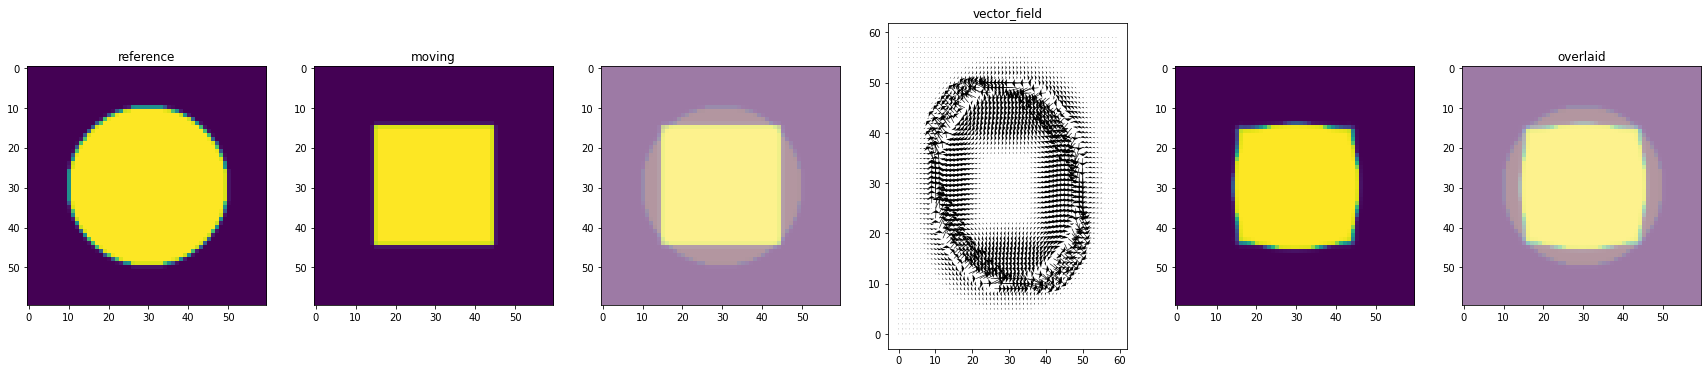

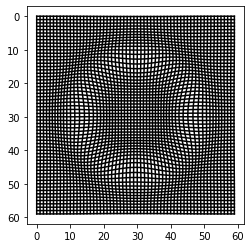

-41.25944462421365 827.44790086346 0.06373890133913933
17.574217926076106


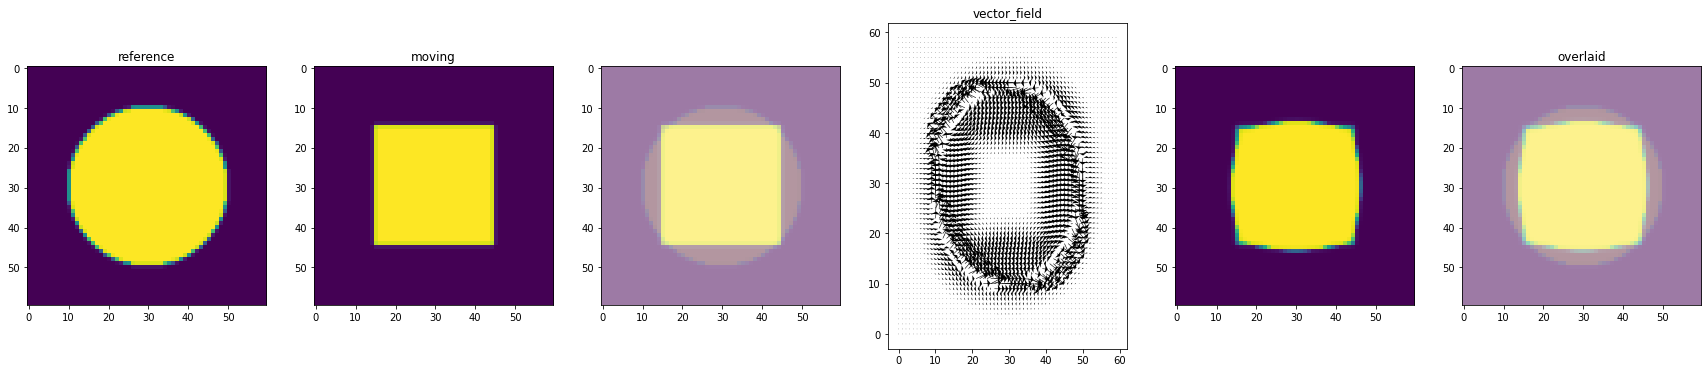

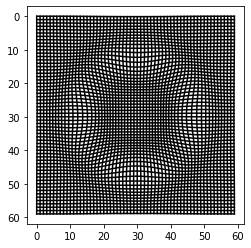

23.937537270043524 689.4151082433303 0.0399481211074587
17.646673894356898


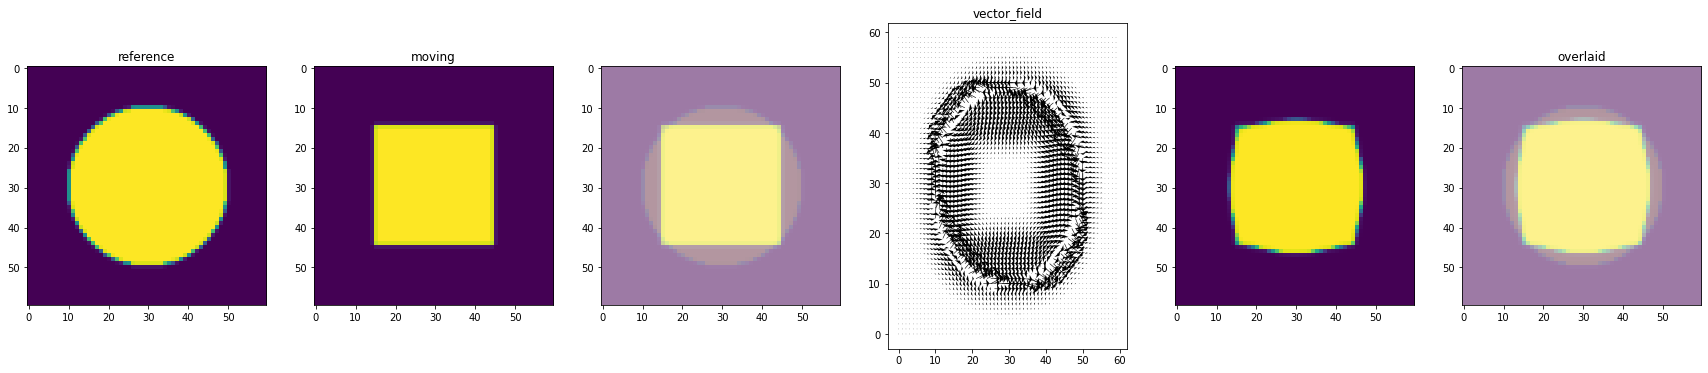

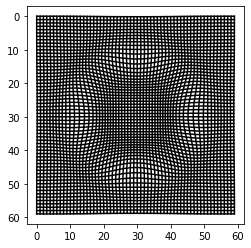

-18.23087597702652 726.3702237870439 0.05803792534075776
16.863888732275278


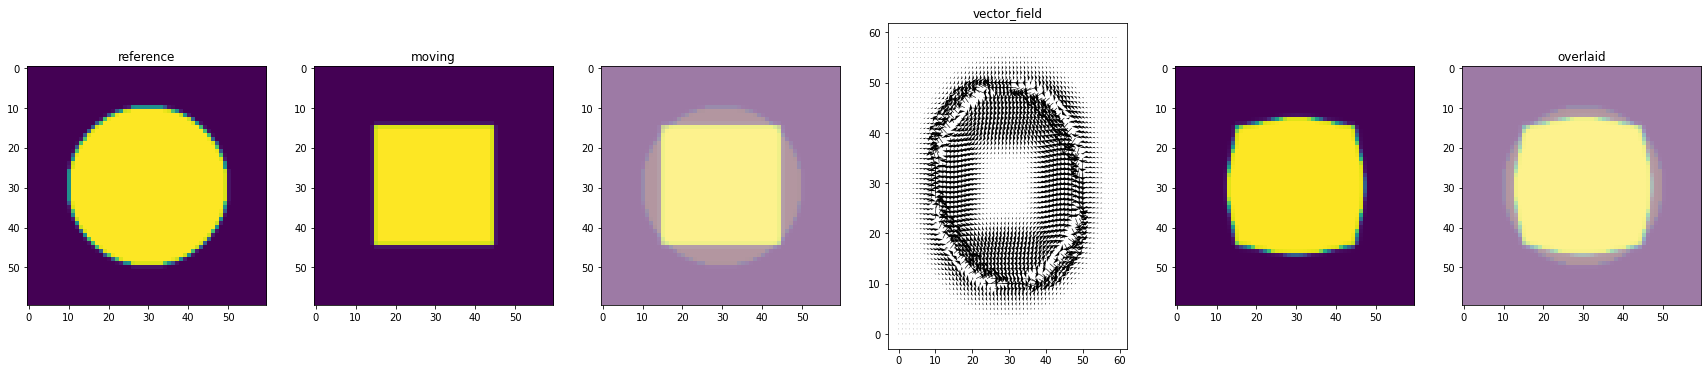

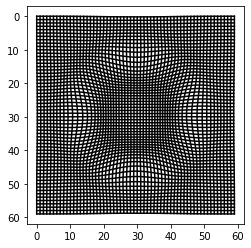

14.0035647513536 1036.819332203902 0.04414869201481981
16.87440185172955


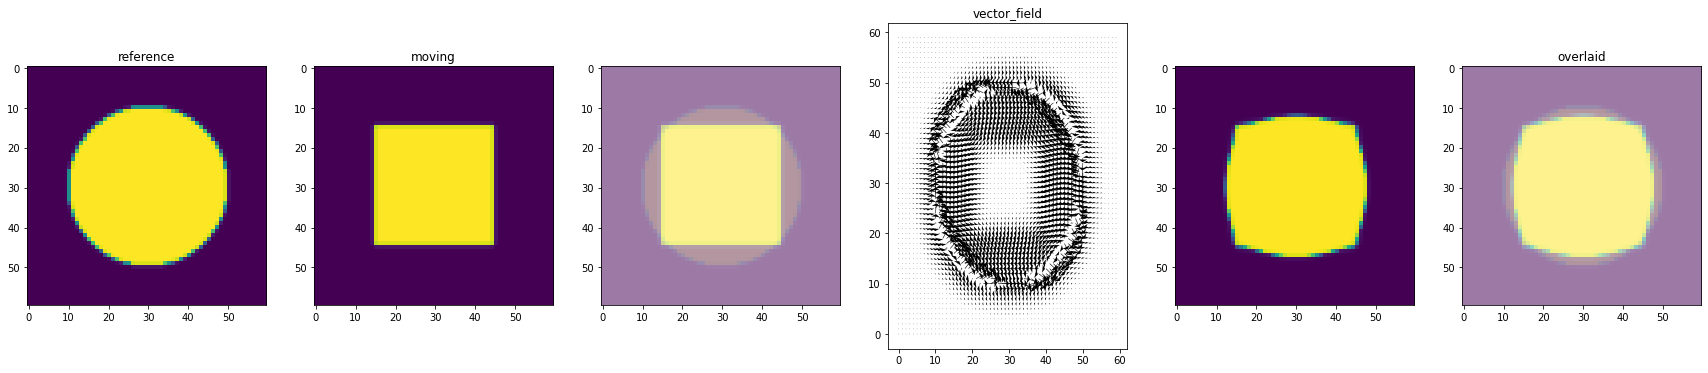

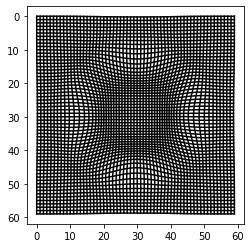

-19.38628919786104 1485.8556148861935 0.06335532024725235
16.103934689329336


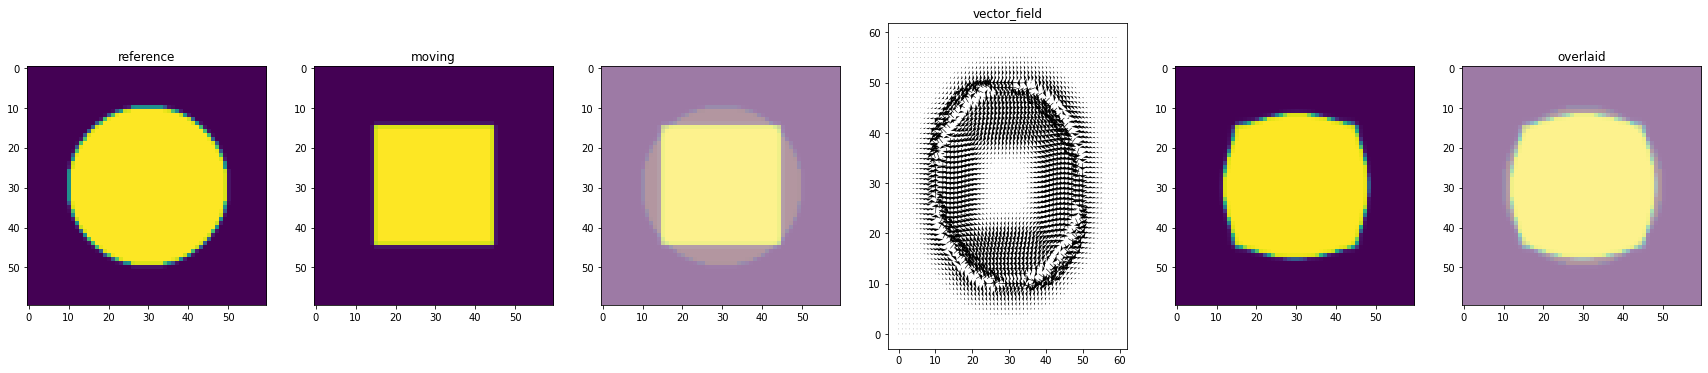

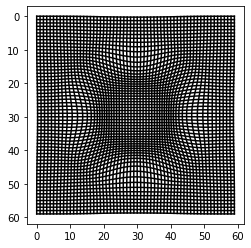

11.752104864359723 2167.0116427318153 0.0517226215979461
15.087774244892366


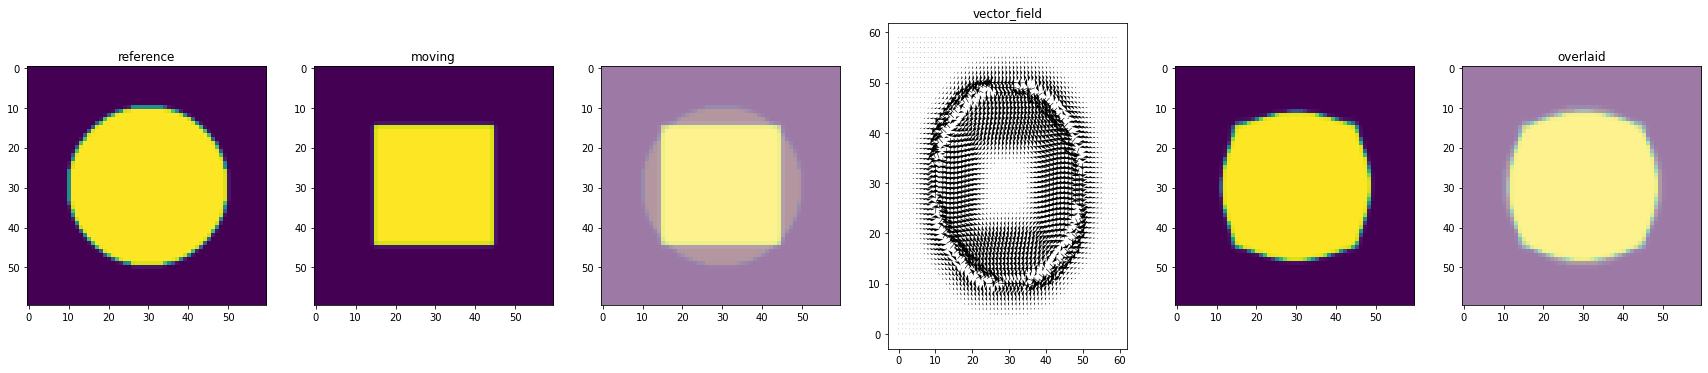

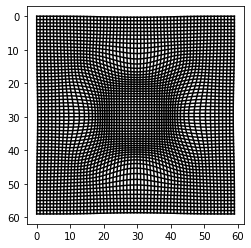

-7.883585261714593 2952.197080411942 0.05946708376792202
14.30620250740845


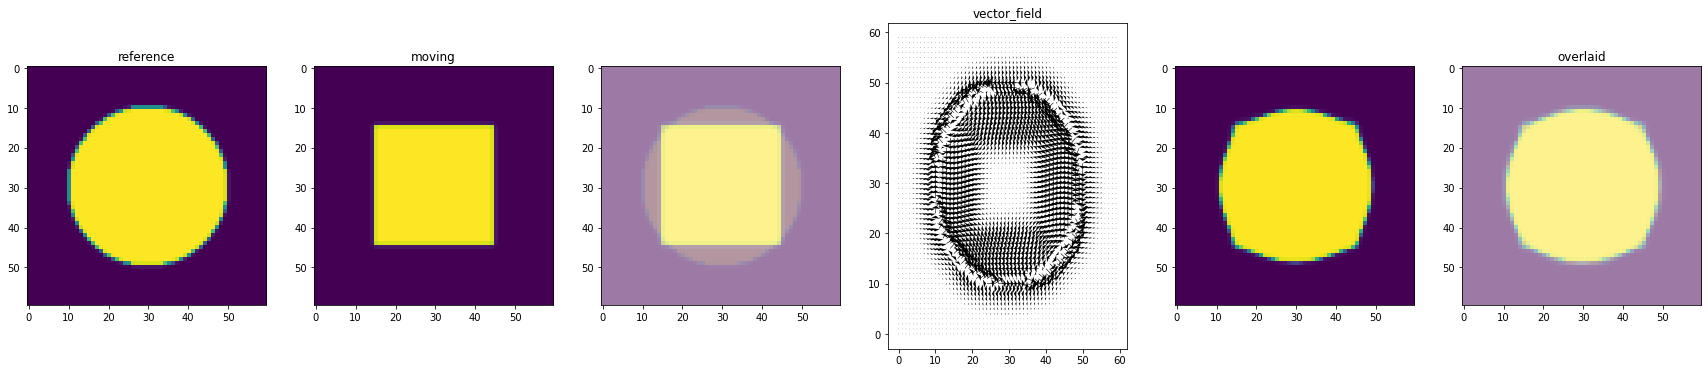

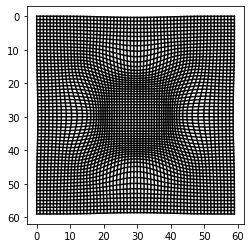

18.17363279815533 3855.4976459158715 0.04149519115471476
11.682035307876772


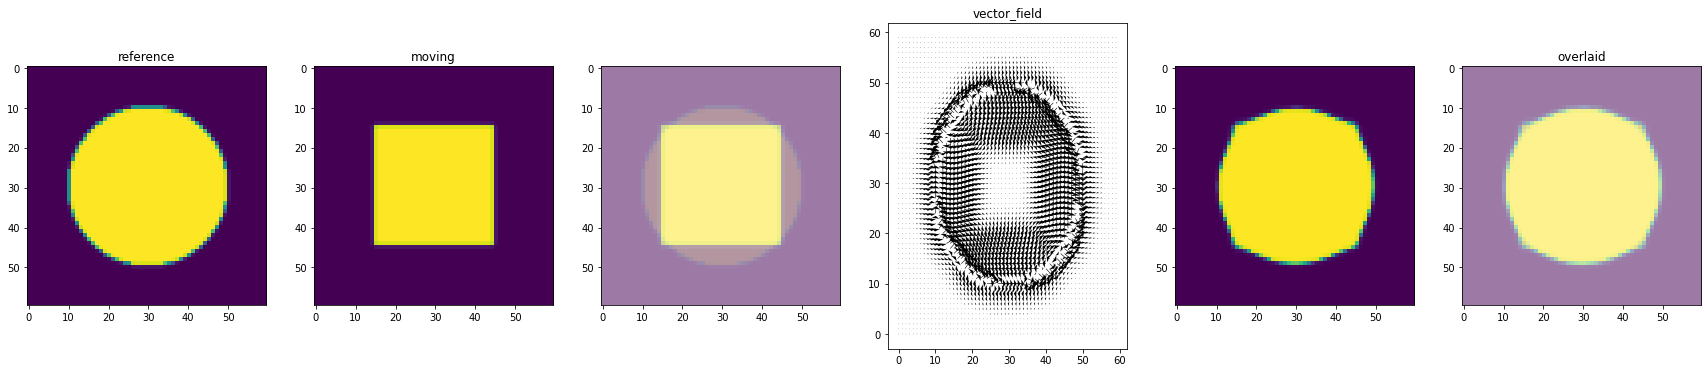

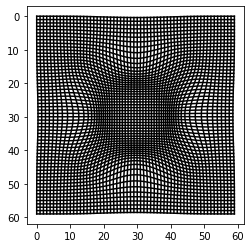

-9.358451645553922 4769.880822441599 0.05068821525708206
9.88173473589968


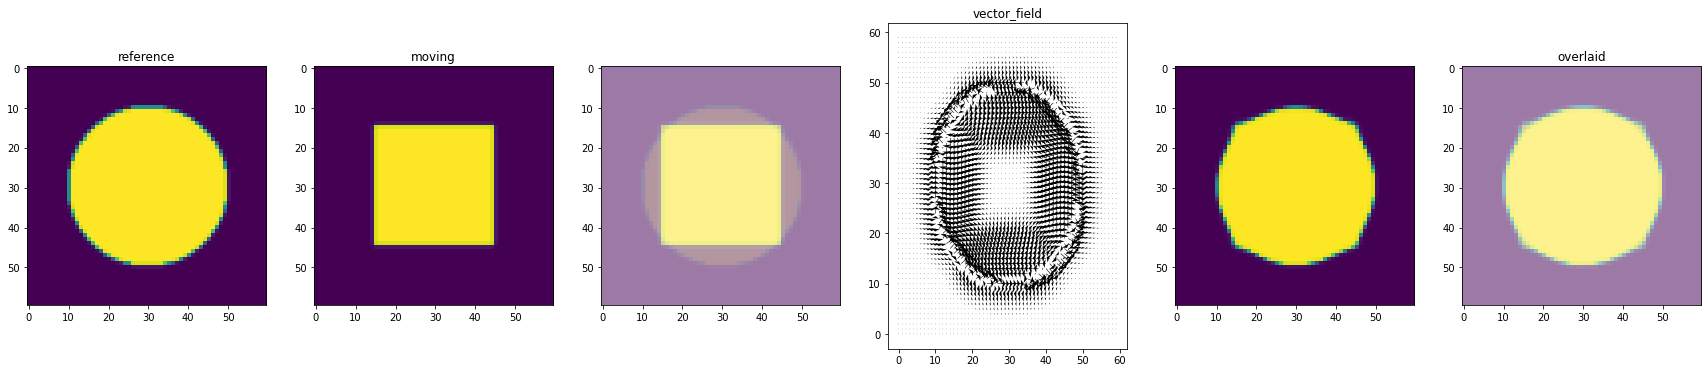

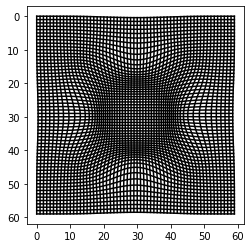

-3.582566345838209 5599.100998090782 0.054204644585528816
5.103012184010154


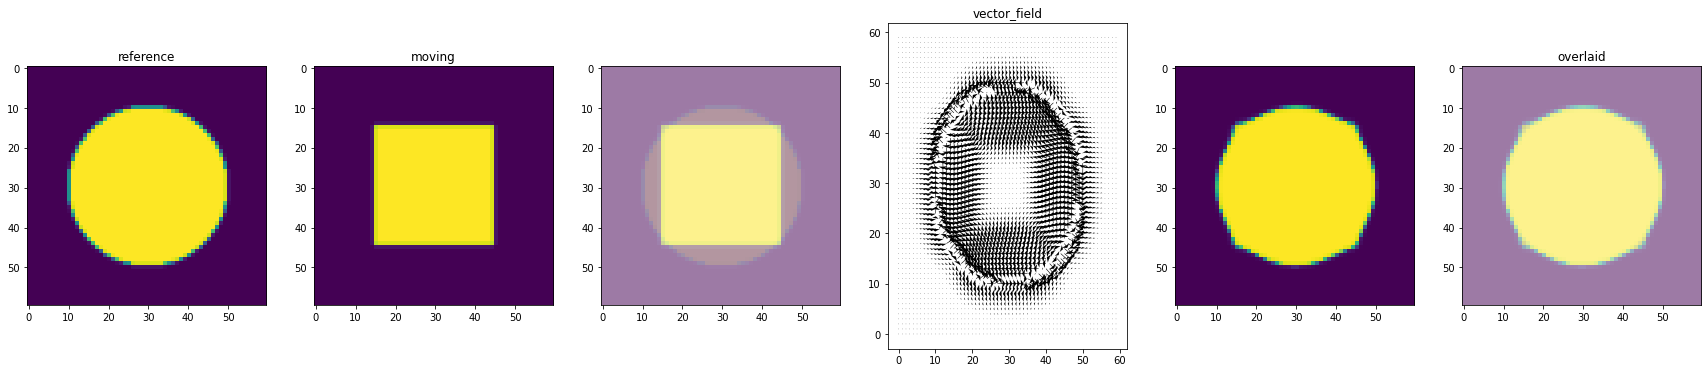

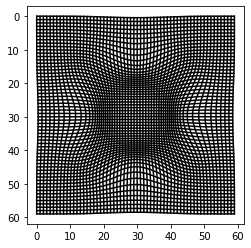

4.035174962770313 6350.4683657842215 0.05021668941170409
3.3113128959193254


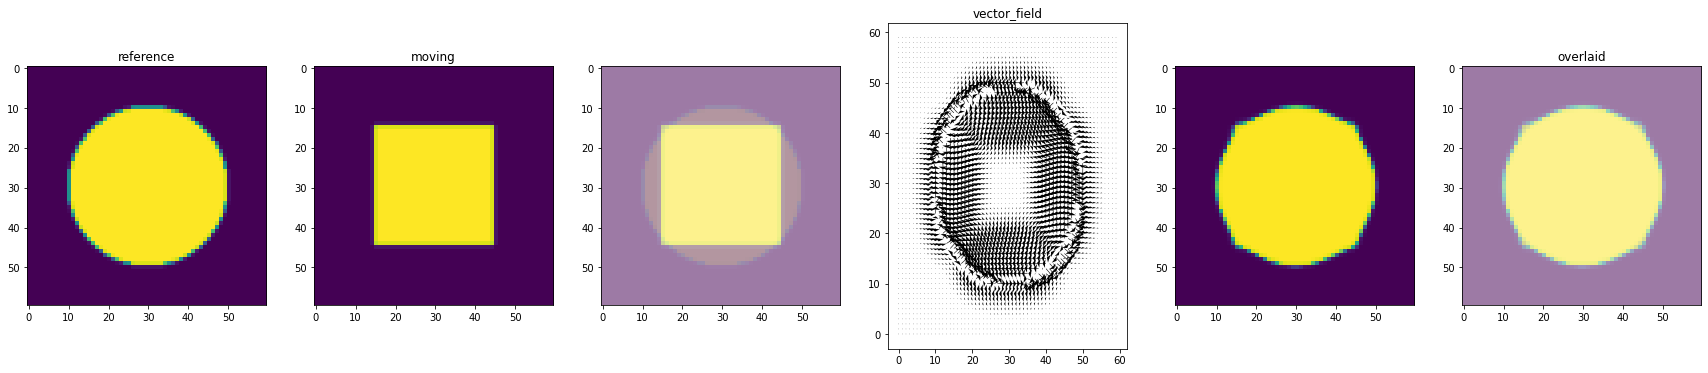

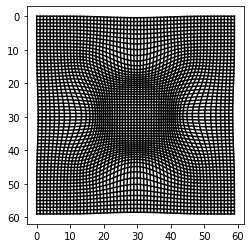

1.6471165290616594 6628.067142423398 0.048595964281892806
3.0269094716195273


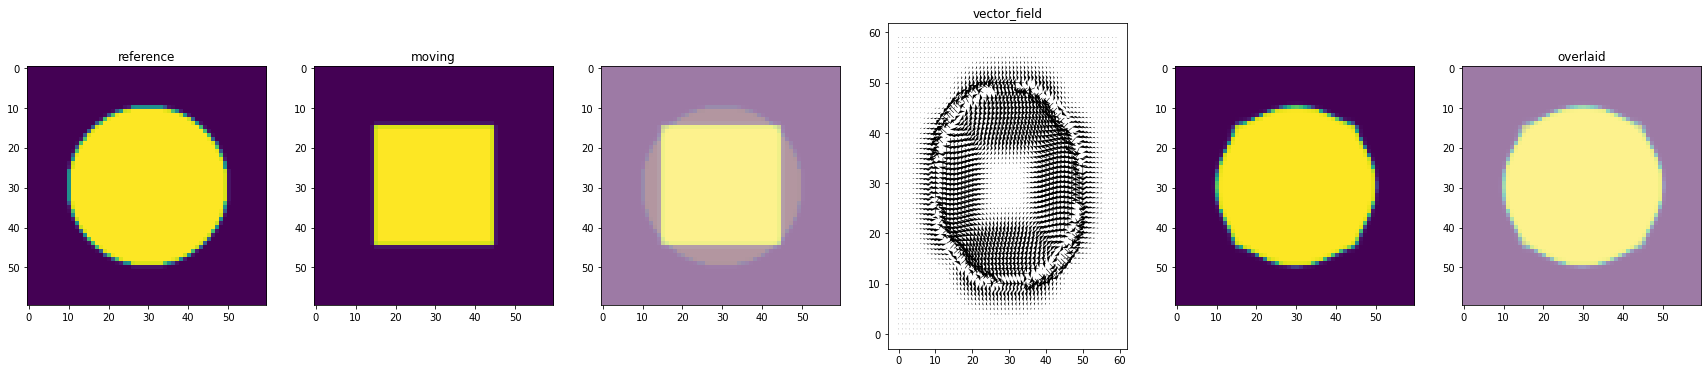

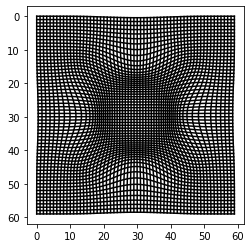

2.14910108122525 6754.442359568539 0.04646652666753731
2.425748248761242


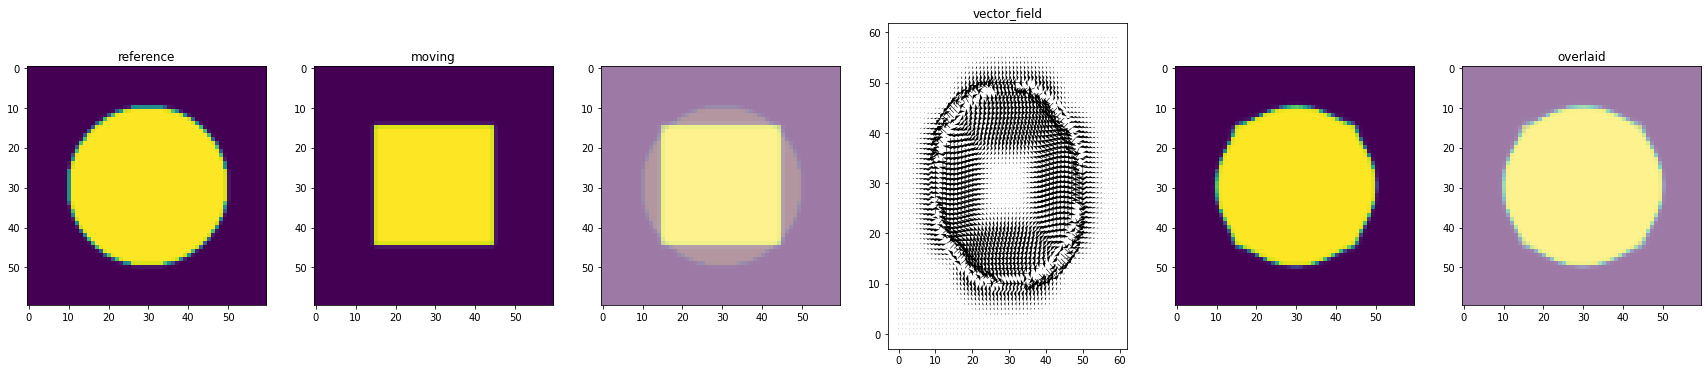

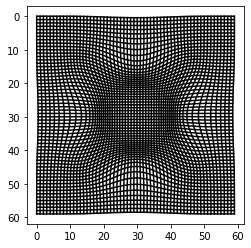

0.09168128488051251 6734.917620447093 0.046381156604435175
2.17784743512533


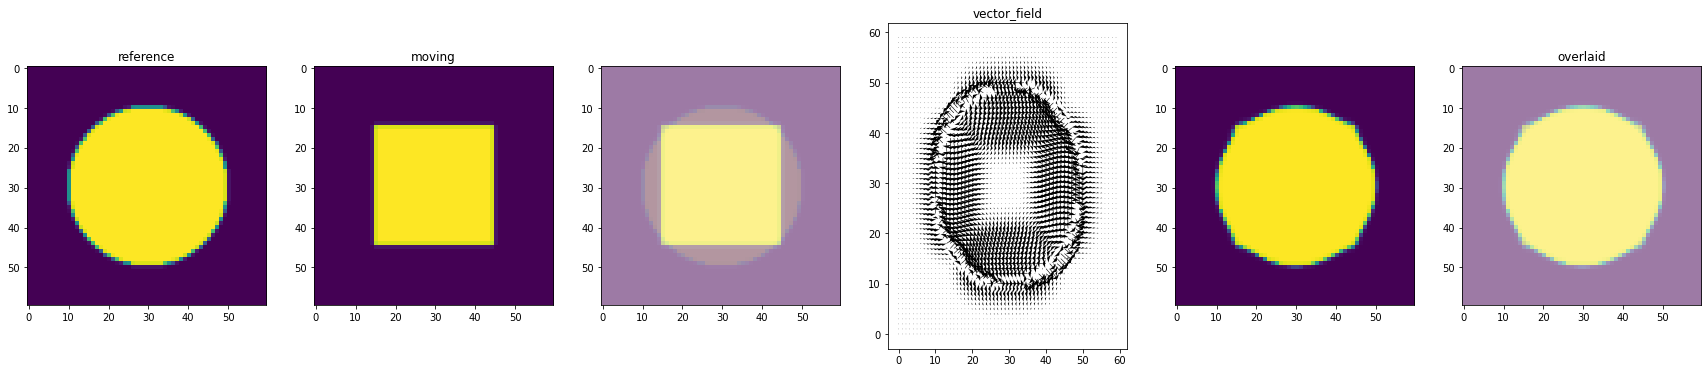

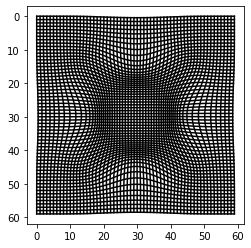

-1.5441075403317623 6756.97069485811 0.04791251414404323
1.9213933757025947


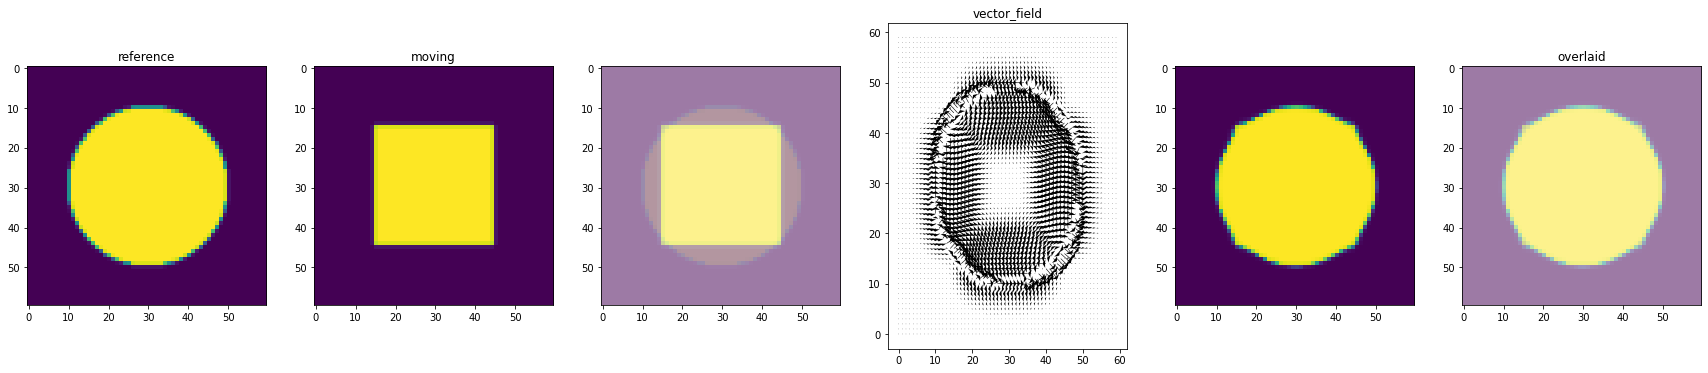

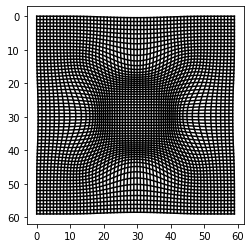

0.3747180447059306 6797.045601032671 0.04754958460984346
2.2756959381336395


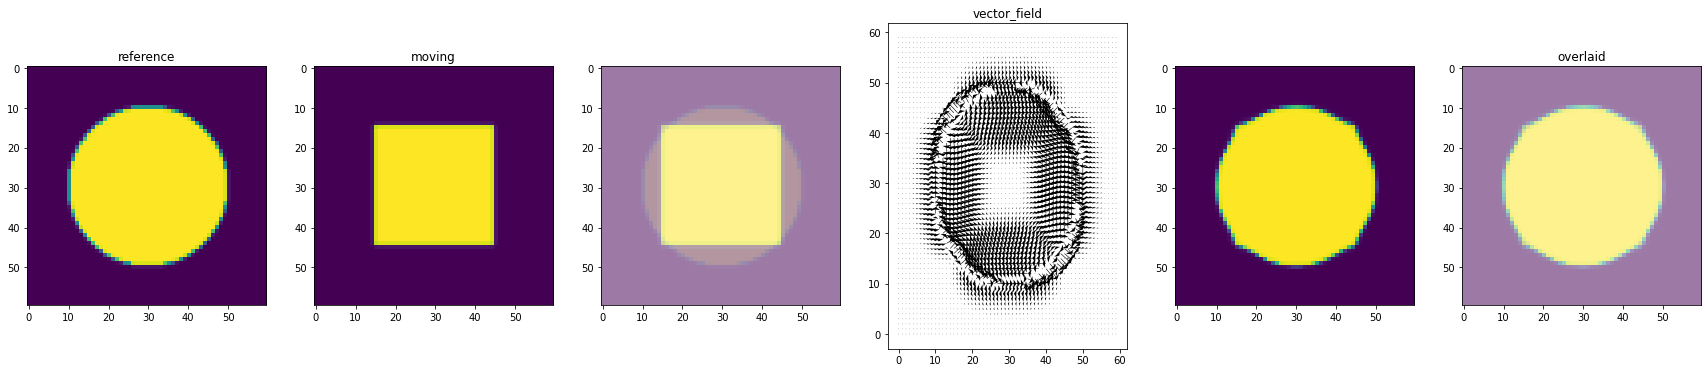

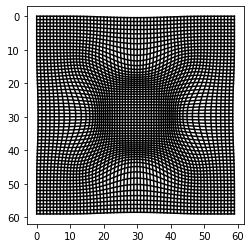

-3.103035081072399 6810.430576852431 0.050641601540586355
1.8919686809076013


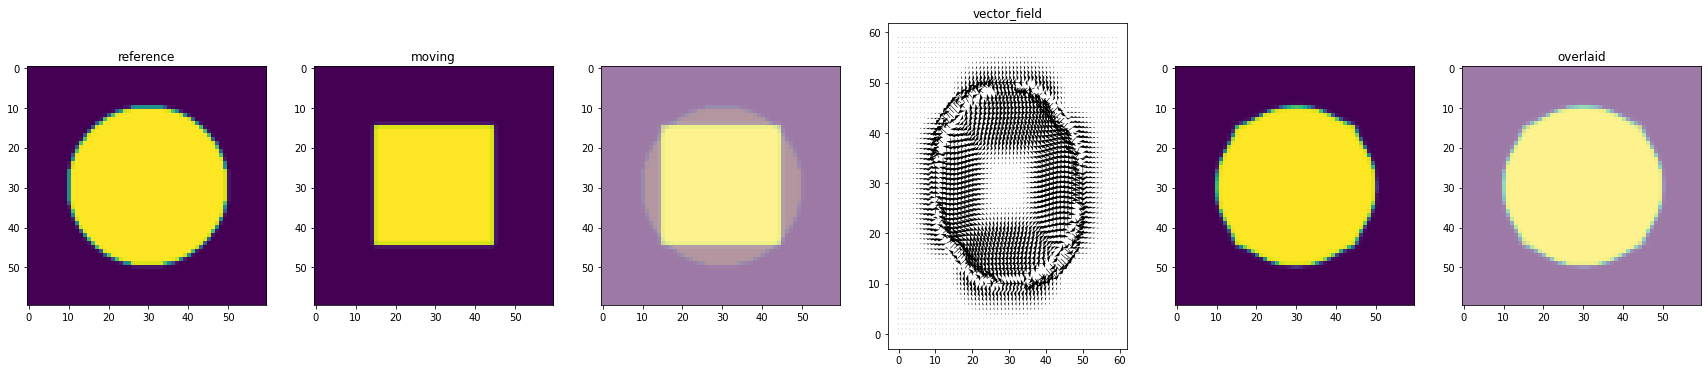

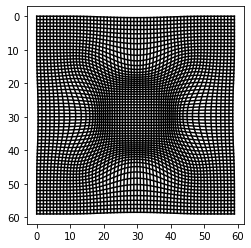

-0.9615195737685722 6807.554282429449 0.05160985703016035
1.6539700791256131


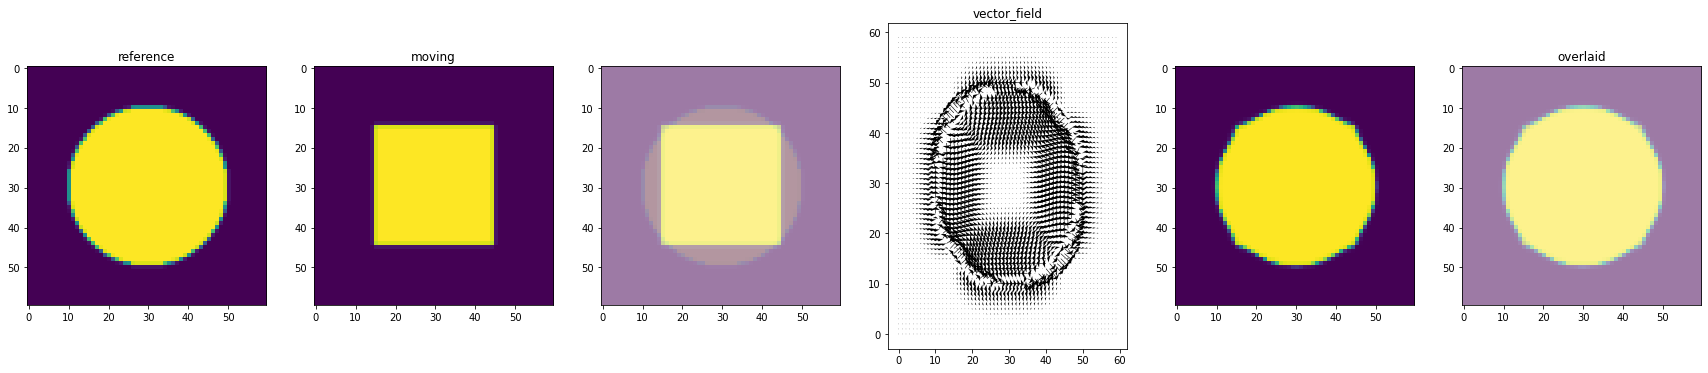

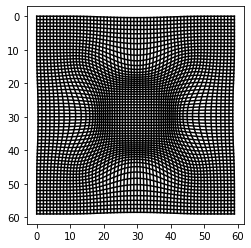

0.22787223292906814 6821.069731644079 0.05139469658697896
1.5084675263388432


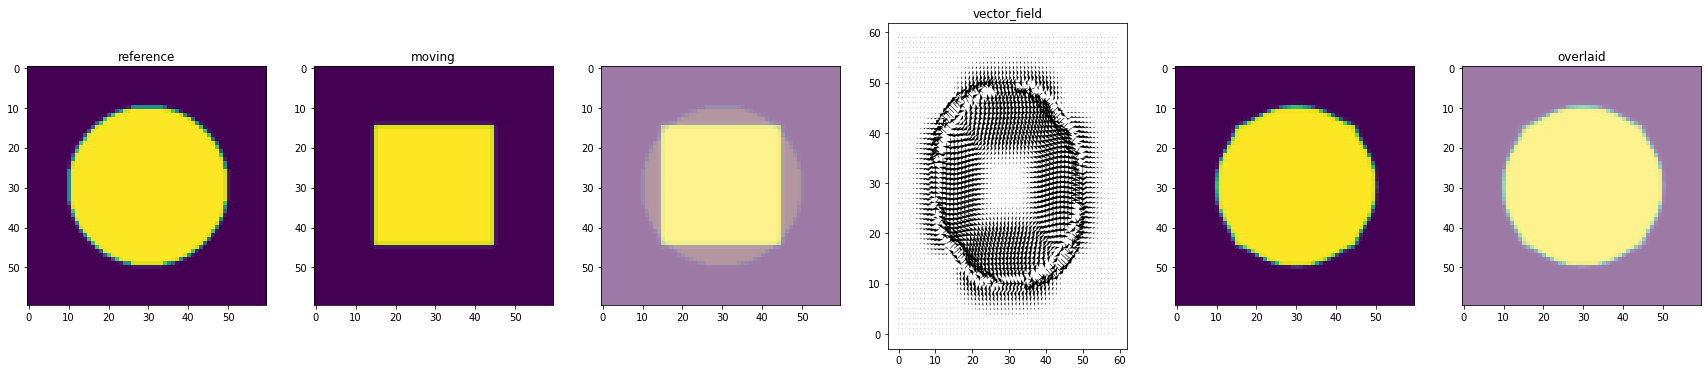

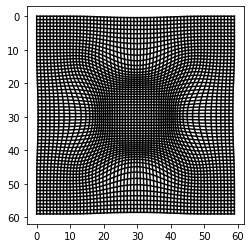

0.24250221659417318 6838.10462484461 0.0511623876568389
1.3836306858325644


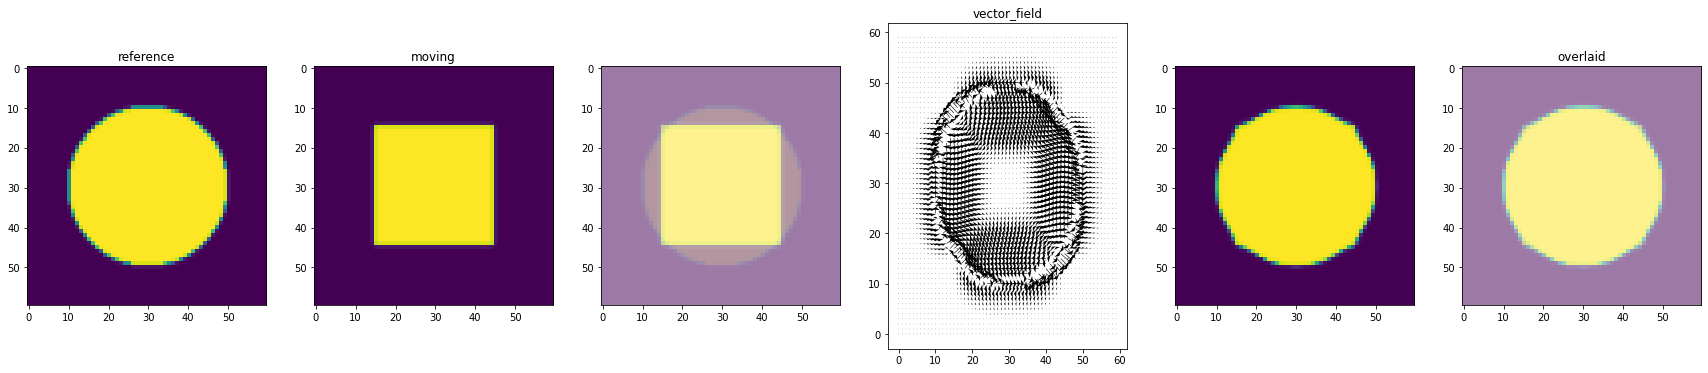

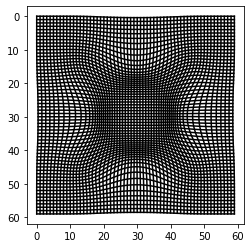

0.23119777845401207 6852.368428922209 0.050939738835186495
1.2765652063183923


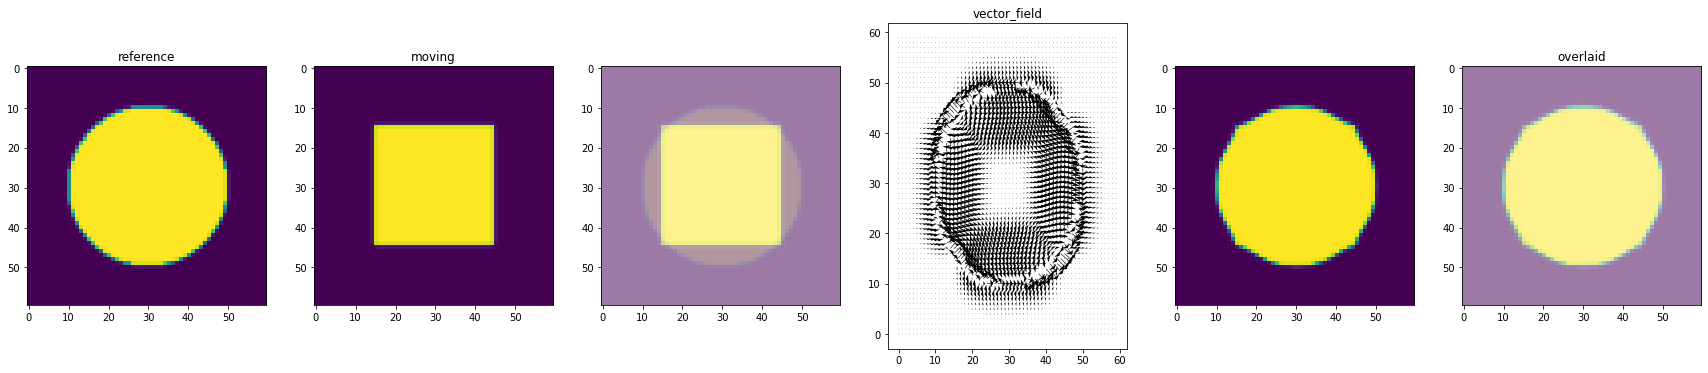

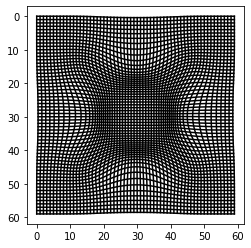

0.3237784365596147 6865.383884782234 0.05062508383728145
1.1880446523940853


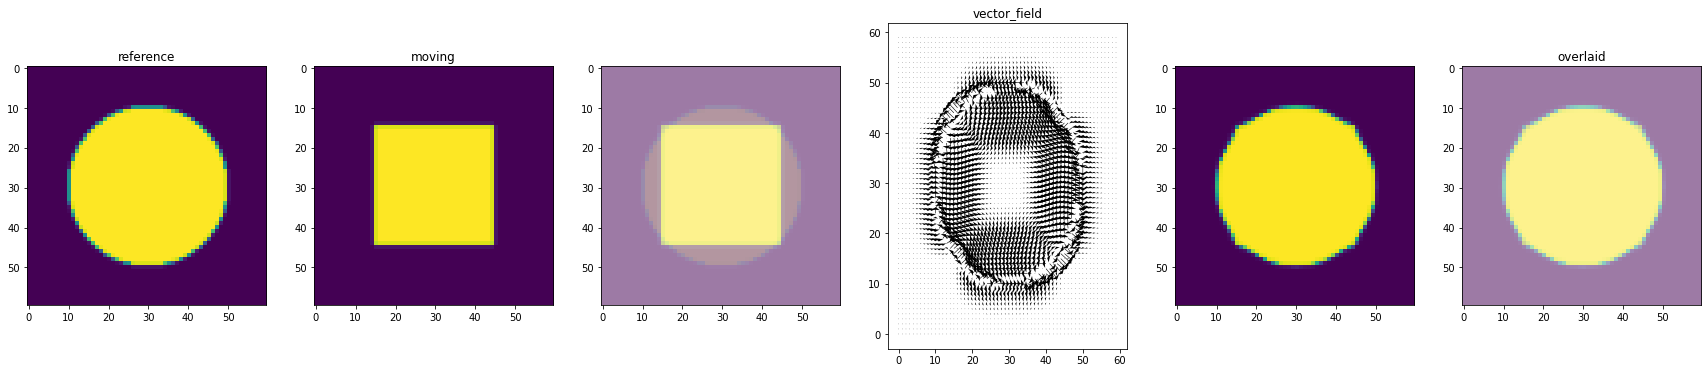

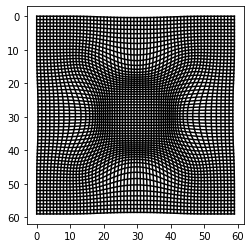

0.49994658274442993 6877.570696820134 0.05013429958679777
1.0883206812935817


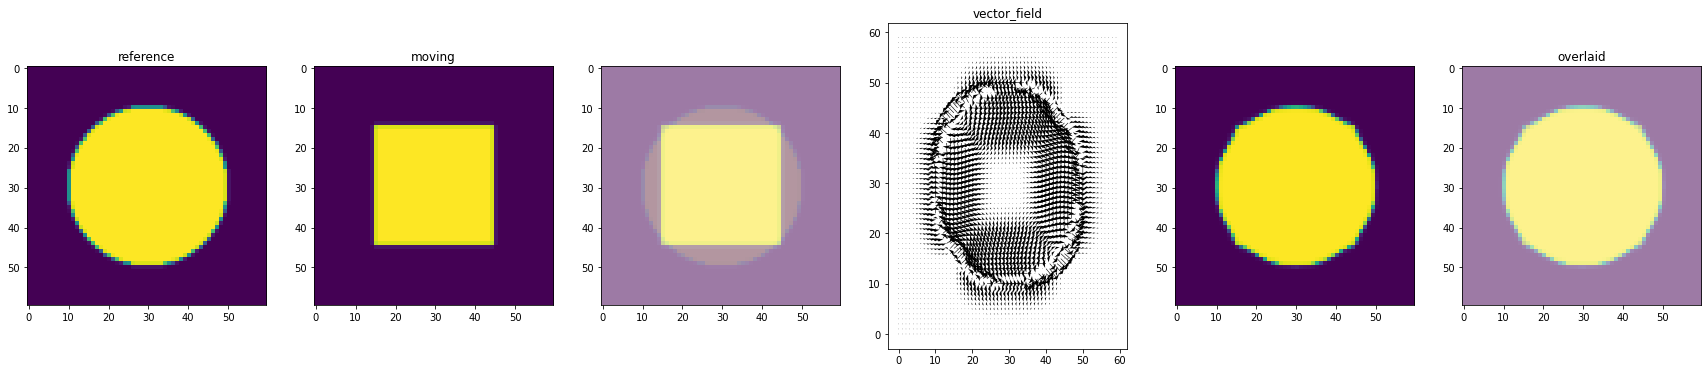

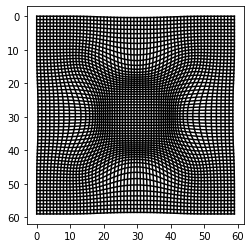

0.1264522847250057 6886.205809966438 0.05001281467368961
1.5422121897486034


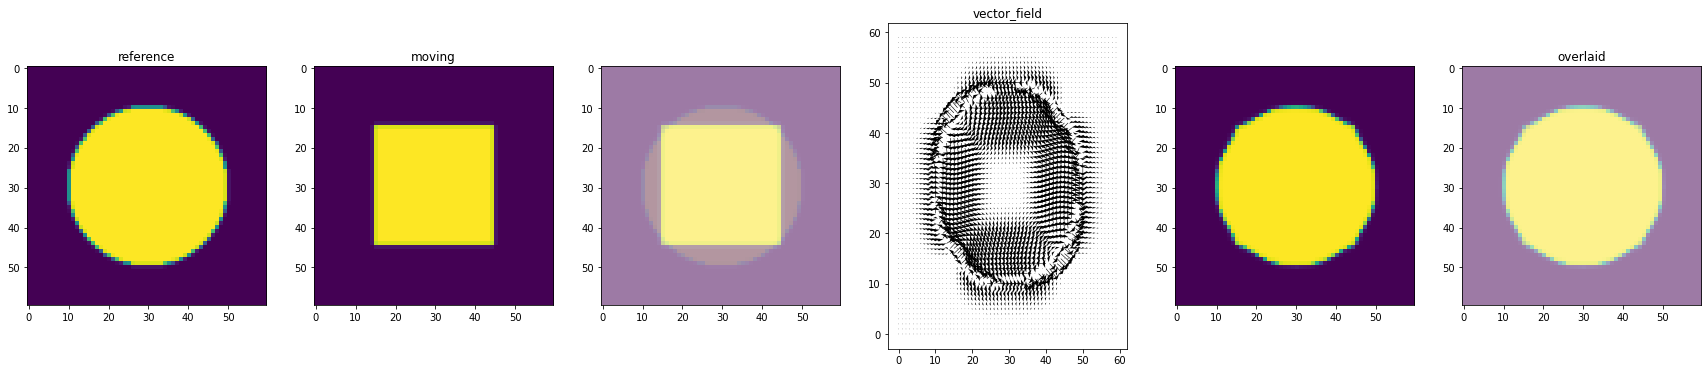

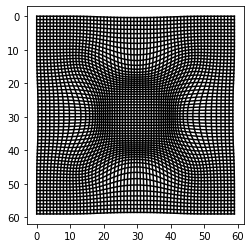

-1.2841383939731044 6896.065628668144 0.05129187706021549
1.6181697619738216


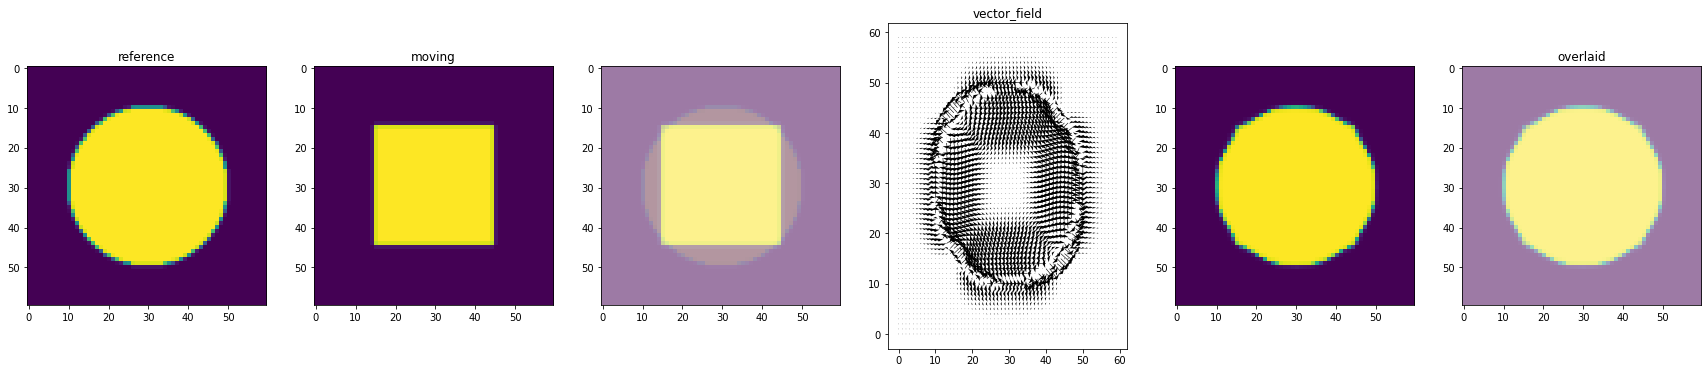

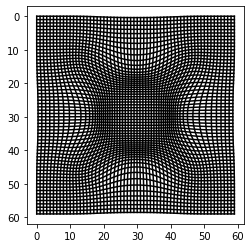

-2.7370617862336792 6888.078621407935 0.054023461652927776
1.6090252409024994


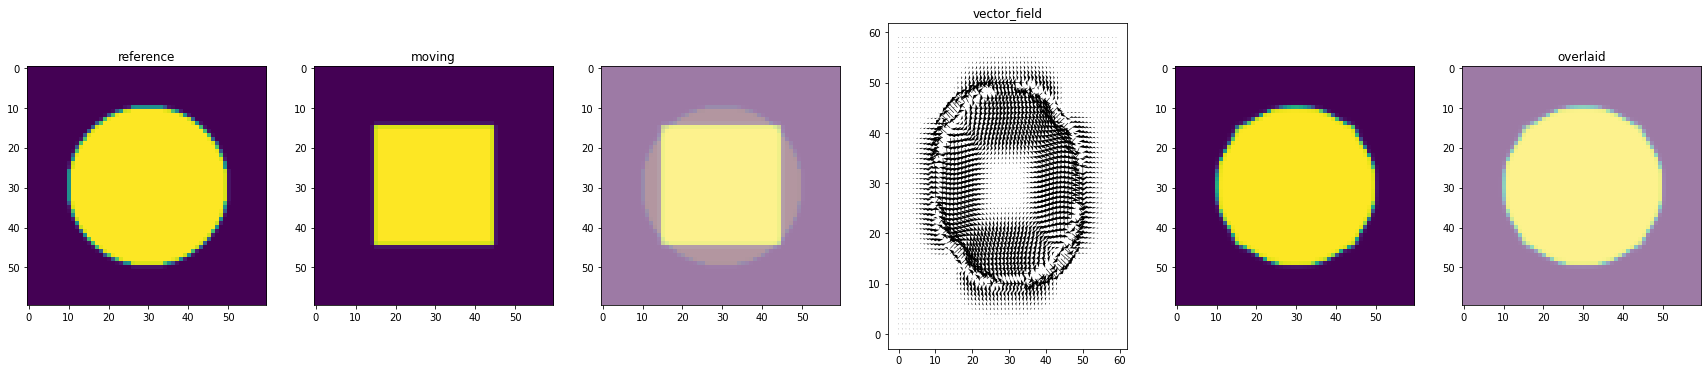

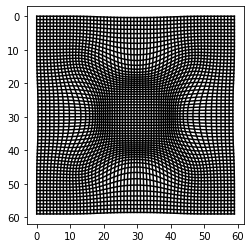

-1.1193201581028733 6903.284228362541 0.055138662134097134


In [26]:
flow_sigma = 4
## smoothers, and integrators and map advection
w, h = fix.shape
smooth_across_components, smooth_across_time_and_components = get_smoother(smooth,  flow_sigma)
id_map = identity_mapping((w, h))
K = get_normalized_gaussian_kernel(id_map,(w//2, h//2), (flow_sigma, flow_sigma) )
eps = 1e-3
x0 = jnp.arange(0, w)
x1 = jnp.arange(0, h)
t = jnp.linspace(0, 1, 32)
m0 = 1e-1*jnp.asarray(jnp.gradient(fix))
sigma = .05
loss_list = []
grad_list = []
grid_list = []


for i in range(30):
        
    
    loss = cost_functional(m0, K, fix, mov, t, sigma, odeint_rk4,smooth_across_components,smooth_across_time_and_components, advect_map_forward, compute_cc, 
                   regularization)
    
    #print(make_jaxpr(cost_functional)(m0, K, fix, mov, t, sigma))
    
    grad_m0 = grad(cost_functional)(m0, K, fix, mov, t, sigma, odeint_rk4,smooth_across_components,smooth_across_time_and_components, advect_map_forward, similarity.ssd, 
                   regularization)
    m0 = m0 - eps*grad_m0
    
    print (jnp.linalg.norm(eps*grad_m0))
    
    m_int = odeint_rk4(get_dm_dt, m0, t, K, smooth_across_components)
    v_int = smooth_across_time_and_components(m_int, K)
    phi_id = identity_mapping(fix.shape)
    phi_ad_x, phi_ad_y = advect_map_forward(get_dphi_dt, phi_id, t, v_int)
    
    coords = jnp.asarray([phi_ad_y, phi_ad_x])
    warped = jax.scipy.ndimage.map_coordinates(mov, coords, order= 1)
    
    u, v = m0
    
    f, a = plt.subplots(1, 6, figsize =(30, 6))
    a[0].imshow(fix)
    a[0].set_title("reference")
    a[1].imshow(mov)
    a[1].set_title("moving")
    a[3].quiver(x0, x1, u, v, headwidth = 15)
    a[3].set_title("vector_field")
    a[2].imshow(fix, alpha = .2)
    a[2].imshow(mov, alpha = .4)
    a[4].imshow(warped)
    a[5].imshow(fix, alpha = .2)
    a[5].imshow(warped, alpha = .4)
    a[5].set_title("overlaid")
    
    
    
    show_warp_field(jnp.asarray([phi_ad_x, phi_ad_y]), interval=1, shape = fix.shape, size = (4, 4),limit_axis=False, show_axis=True, plot_separately = False)
    
    grid_list.append(jnp.asarray([phi_ad_x, phi_ad_y]))
    plt.show()
    
    
    loss_list.append(loss)
    grad_list.append(jnp.mean(grad_m0))
    
    
    print (jnp.mean(grad_m0), loss, jnp.mean(v_int))
    